In [252]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd
import zipfile

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import shutil
import glob
from tika import parser

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielacollaguazo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data into DataFrame

In [2]:
def create_data_frame(csv_path):
    df = pd.read_csv(csv_path)
    return df

In [3]:
path = '../data/austin-airbnb/'
calendar_csv = os.path.join(path,'calendar.csv')
listings_csv = os.path.join(path,'listings.csv')
neighborhoods_csv = os.path.join(path,'neighborhoods.csv')

calendar_df = create_data_frame(calendar_csv)
listings_df = create_data_frame(listings_csv)
neighborhoods_df = create_data_frame(neighborhoods_csv)

/Users/danielacollaguazo/anaconda/envs/GTWorkshops/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Exploring DataFrames

In [4]:
# calendar_df.head()
# calendar_df.shape
# neighborhoods_df.head()

In [5]:
# listings_df.head()
# Looking for text in the data
listings_df.dtypes

# # iterating the columns 
# for col in listings_df.columns: 
#     print(col)

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [253]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [256]:
listings_df['content'] = listings_df['name'] + listings_df['summary']
listings_df.dropna(subset=['content'], how='any', axis=0, inplace=True)
listings_df['content_lang'] = listings_df.content.apply(lambda x: predict_lang(x))

In [257]:
listings_df.shape

(11244, 108)

In [258]:
# getting only text in English
listings_df=listings_df[listings_df.content_lang=='en']

In [260]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [261]:
lst_texts = generate_list_content(listings_df)
# listings_df['content']

In [263]:
len(lst_texts)

11169

## Tokenize words and clean up text

In [264]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [265]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [266]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [267]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [268]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

## Build list of topic models

In [269]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

In [270]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [271]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.802208,0.363775,2
1,-6.814640,0.481708,3
2,-6.851684,0.509196,4
3,-6.867068,0.377042,5
4,-6.908345,0.367520,6
5,-6.936621,0.435445,7
6,-6.987970,0.358415,8
7,-7.059409,0.425991,9
8,-7.171324,0.352549,10
9,-7.342536,0.394595,11


## Graphic of number of Topics and Perplexity

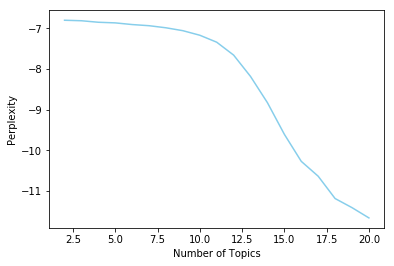

In [272]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

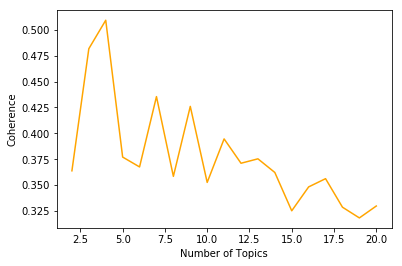

In [273]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Most salient topic per file using results of Model of choice

In [37]:
# def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1, 
#                                                                   round(prop_topic,4), 
#                                                                   topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
# #     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([listings_df,sent_topics_df], axis=1, sort=False)
#     return(sent_topics_df)

## DataFrame with scores of all topics

In [274]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4']
    sent_topics_df = pd.concat([listings_df.id,sent_topics_df], axis=1, sort=False)
    sent_topics_df.set_index('id',inplace=True)
    
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [275]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[2], corpus=corpus, texts=lst_texts)

In [276]:
sent_topics_df.head()

,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4
id,,,,
2265.0,"(1, 0.7008473)","(2, 0.1430584)","(0, 0.13544367)","(3, 0.020650616)"
5245.0,"(1, 0.6823926)","(0, 0.10962439)","(2, 0.10536952)","(3, 0.1026135)"
5456.0,"(1, 0.55133057)","(0, 0.27828813)","(3, 0.12623918)","(2, 0.044142075)"
NaN,"(1, 0.9201705)","(0, 0.03157466)","(2, 0.027566724)","(3, 0.020688113)"
6413.0,"(1, 0.47267914)","(0, 0.33425727)","(2, 0.10902779)","(3, 0.084035814)"


In [277]:
for i in range(df_n_cols):
    col = 'score_dom_topic_' + str(i)
    sent_topics_df[col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [278]:
sent_topics_df.head()

,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,score_dom_topic_0,score_dom_topic_1,score_dom_topic_2,score_dom_topic_3
id,,,,,,,,
2265.0,"(1, 0.7008473)","(2, 0.1430584)","(0, 0.13544367)","(3, 0.020650616)",0.700847,0.143058,0.135444,0.020651
5245.0,"(1, 0.6823926)","(0, 0.10962439)","(2, 0.10536952)","(3, 0.1026135)",0.682393,0.109624,0.105370,0.102614
5456.0,"(1, 0.55133057)","(0, 0.27828813)","(3, 0.12623918)","(2, 0.044142075)",0.551331,0.278288,0.126239,0.044142
NaN,"(1, 0.9201705)","(0, 0.03157466)","(2, 0.027566724)","(3, 0.020688113)",0.920170,0.031575,0.027567,0.020688
6413.0,"(1, 0.47267914)","(0, 0.33425727)","(2, 0.10902779)","(3, 0.084035814)",0.472679,0.334257,0.109028,0.084036


In [279]:
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [280]:
sent_topics_df.head()

,score_dom_topic_0,score_dom_topic_1,score_dom_topic_2,score_dom_topic_3
id,,,,
2265.0,0.700847,0.143058,0.135444,0.020651
5245.0,0.682393,0.109624,0.105370,0.102614
5456.0,0.551331,0.278288,0.126239,0.044142
NaN,0.920170,0.031575,0.027567,0.020688
6413.0,0.472679,0.334257,0.109028,0.084036


### Visualize the topics

In [281]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[2], corpus, id2word)
vis

/Users/danielacollaguazo/anaconda/envs/GTWorkshops/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.257746  0.262729       1        1  66.292648
2     -0.027421 -0.135343       2        1  12.891780
0      0.107502 -0.257031       3        1  12.869589
3     -0.337827  0.129644       4        1   7.945974, topic_info=     Category         Freq              Term        Total  loglift  logprob
83    Default  3097.000000              stay  3097.000000  30.0000  30.0000
9     Default  8104.000000          downtown  8104.000000  29.0000  29.0000
27    Default  2382.000000             space  2382.000000  28.0000  28.0000
239   Default  1546.000000             place  1546.000000  27.0000  27.0000
127   Default  1407.000000             guest  1407.000000  26.0000  26.0000
669   Default  1236.000000             right  1236.000000  25.0000  25.0000
13    Default  4424.000000              home  4424.000000  24.0000  24.0000
45    Default  1124.000000              wifi  1124.000000  23.0000  23.0000
183   Default  1296.000000             relax  1296.000000  22.0000  22.0000
190   Default   853.000000               day   853.000000  21.0000  21.0000
121   Default  1693.000000            modern  1693.000000  20.0000  20.0000
1273  Default   759.000000     complimentary   759.000000  19.0000  19.0000
174   Default   829.000000              view   829.000000  18.0000  18.0000
1776  Default   664.000000              sure   664.000000  17.0000  17.0000
105   Default   806.000000          property   806.000000  16.0000  16.0000
116   Default   761.000000           feature   761.000000  15.0000  15.0000
123   Default  3768.000000              room  3768.000000  14.0000  14.0000
31    Default   921.000000             clean   921.000000  13.0000  13.0000
98    Default   914.000000           outdoor   914.000000  12.0000  12.0000
30    Default  3531.000000              walk  3531.000000  11.0000  11.0000
460   Default  1934.000000          bathroom  1934.000000  10.0000  10.0000
221   Default  3339.000000            minute  3339.000000   9.0000   9.0000
141   Default  3278.000000           bedroom  3278.000000   8.0000   8.0000
61    Default  3200.000000           private  3200.000000   7.0000   7.0000
51    Default  2248.000000            coffee  2248.000000   6.0000   6.0000
2618  Default   502.000000               web   502.000000   5.0000   5.0000
71    Default  1043.000000       comfortable  1043.000000   4.0000   4.0000
609   Default   554.000000             couch   554.000000   3.0000   3.0000
4663  Default   476.000000              surf   476.000000   2.0000   2.0000
1555  Default   475.000000      cotton_sheet   475.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
7329   Topic4   473.862823  mattresses_fitte   474.537262   2.5311  -3.8878
7330   Topic4   472.576416   restful_slumber   473.249725   2.5311  -3.8905
1250   Topic4   439.413879      high_quality   440.100586   2.5309  -3.9633
97     Topic4   404.225769             night   404.948578   2.5307  -4.0468
559    Topic4   411.922394              hide   412.673492   2.5307  -4.0279
1019   Topic4   309.243591             start   309.926270   2.5303  -4.3146
7866   Topic4   304.152893        hdtv_youll   304.904114   2.5300  -4.3312
294    Topic4   275.323273           retreat   276.054626   2.5299  -4.4308
529    Topic4   258.160919            little   258.899841   2.5296  -4.4951
812    Topic4   250.181808               set   250.946014   2.5295  -4.5265
605    Topic4   232.557983              part   233.295929   2.5293  -4.5996
518    Topic4   213.591232              able   214.299210   2.5292  -4.6847
769    Topic4   204.095261               dog   204.804626   2.5290  -4.7301
485    Topic4   189.765808         luxurious   190.504532   2.5286  -4.8029
285    Topic4   182.320724              cool   183.047684   2.5285  -4.8430
292    Topic4   185.865616          peaceful   186.606735   2